# Characterize the "effective f-ratio" of beams entering the Offner spectrograph for Tiger and Bigre configurations from the MLA

*A. Bolton, 2023 Apr*

 * Define end-to-end optical system for Tiger and Bigre configurations
   + Telescope
   + Microlens array
   + Spectrograph
   + Detector
 * Examine intensity at the location of the first prism


In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import poppy
from poppy.poppy_core import PlaneType
#from poppy.sub_sampled_optics import Subapertures, ShackHartmannWavefrontSensor
import astropy.units as u
import astropy.io.fits as fits
import copy

In [2]:
# End-to-end model parameters

# Telescope:
fl_pri = 3607.5 * u.m  # primary beam focal length (effective, after magnifier)
diam = 6.5 * u.m       # primary aperture diameter
sec_rad = 0.65 * u.m   # secondary radius
n_supp = 3             # number of secondary supports
supp_wid = 0.15 * u.m  # width of secondary supports

# Common MLA parameters:
spaxel_size = 700.e-6 * u.m   # spaxel size
spaxel_arcsec = (206265. * spaxel_size / fl_pri).value # spaxel size in arcsec (COMPUTED)

# Tiger MLA parameters:
fl_tiger = 11.1e-3 * u.m         # focal length of Tiger MLA lenslet
dsize_tiger = 100.e-6 * u.m   # size of Tiger diaphragm mask aperture
imdist_tiger = 1./(1./fl_tiger - 1./fl_pri) # Tiger micropupil image distance (COMPUTED)

# Bigre MLA parameters:
fl_bigre_1 = 14.68e-3 * u.m  # focal length of first Bigre MLA lenslet
fl_bigre_2 = 0.42e-3 * u.m   # focal length of second Bigre MLA lenslet
dsize_bigre = 30.e-6 * u.m   # size of Bigre diaphragm mask aperture
imdist_bigre = fl_bigre_2*(1.+fl_bigre_2/fl_bigre_1) # Bigre microslit image distance (COMPUTED)

# Spectrograph parameters:

#### Old form of specification, possibly buggy:
## imdist_spec = 250.e-3 * u.m # Quantity called "focal length" but interpreted as not exactly that
## fratio_spec = 8             # Spectrograph focal ratio
## fl_m1m3 = 0.5 * imdist_spec # Focal length of m1 & m3 (COMPUTED)
## dsize_m2 = 40.e-3 * u.m     # Size of m2
## offset_m2 = fratio_spec * dsize_m2 - imdist_spec # offset of m2 from m1 & m3 (COMPUTED)
## fl_m2 = 0.5 * (offset_m2 - imdist_spec) # focal length of m2 (negative) (COMPUTED)

#### New form of specification:
#### [for offset_m2 cf. zemax & np.hypot(358.20-182.96,85.545-59.665) = 177.14]
pr_dist = 175.477e-3 * u.m      # Distance to first surface of first prism (SOMETIMES USED)
roc_m1m3 = -351.4938e-3 * u.m   # Radius of curvature of (concave) m1 & m3
roc_m2 = 164.3909e-3 * u.m      # Radius of curvature of (convex) m2
fl_m1m3 = -0.5 * roc_m1m3       # Focal length of m1 & m3 (COMPUTED)
fl_m2 = -0.5 * roc_m2           # Focal length of m2 (COMPUTED)
offset_m2 = -roc_m1m3 - roc_m2  # Notional m2 offset from m1/m3 (COMPUTED)
imdist_spec = -roc_m1m3         # image/object-plane distances from m1 & m3 (COMPUTED)
dsize_m2 = 45.e-3 * u.m         # Diameter of m2
dsize_m1m3 = 270.e-3 * u.m      # Diameter of m1/m3 (CURRENTLY NOT USED)
fratio_spec = (imdist_spec - offset_m2) / dsize_m2 # sepctrograph focal ratio (COMPUTED, CURRENTLY NOT USED)

# Detector parameters:
detscale = 1. * u.micron/u.pixel  # pixel scale of detector (nominal = 10um/pix; finer to super-resolve)
#detfov = 64 * u.pixel             # number of pixels across detector
detfov = 100 * u.pixel             # number of pixels across detector

# Computational parameters:
npix = 1024              # number of pixels across pupil
pupil_diam = 2.5 * diam   # Diameter of area to sample

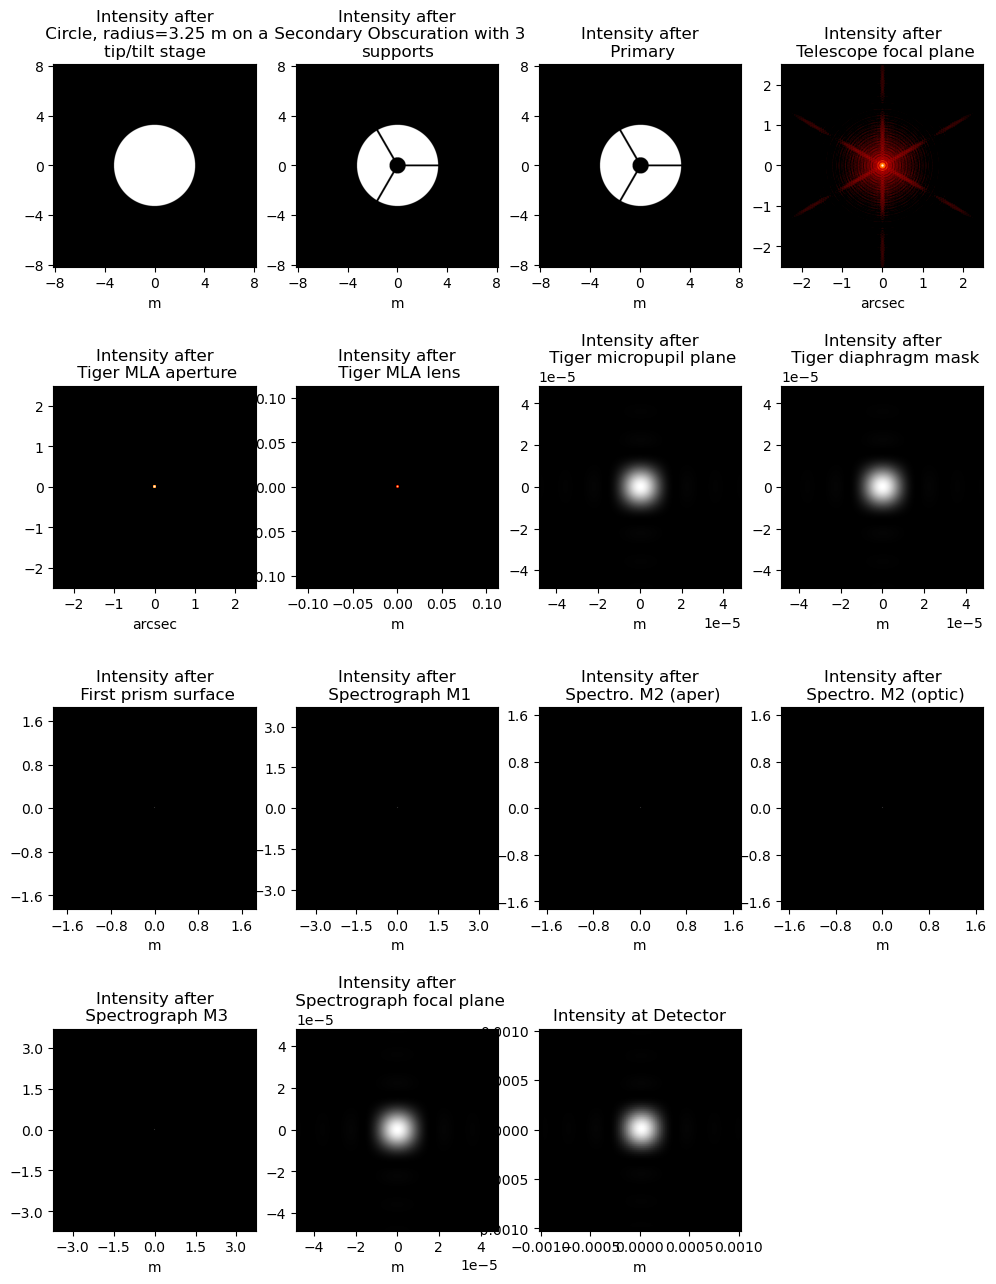

In [3]:
# DEFINE TIGER VERSION

sys_tiger = poppy.FresnelOpticalSystem(pupil_diameter=pupil_diam, npix=npix)
# Primary aperture:
prim_ap = poppy.CircularAperture(radius=diam/2.)
# Tip-tilt stage (to walk telescope PSF over spaxel):
ttstage = poppy.TipTiltStage(prim_ap, radius=diam/2.)
# Put primary+stage into system:
sys_tiger.add_optic(ttstage)
# Include secondary obscuration:
sys_tiger.add_optic(poppy.SecondaryObscuration(secondary_radius=sec_rad,
                                               n_supports=n_supp,
                                               support_width=supp_wid))
# Add lens to represent focusing effect of primary + magnifier:
sys_tiger.add_optic(poppy.QuadraticLens(fl_pri, name='Primary'))
# Establish telescope focal plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image,
                                             name='Telescope focal plane'),
                    distance=fl_pri)
# Add MLA aperture:
sys_tiger.add_optic(poppy.SquareFieldStop(size=1.*spaxel_arcsec,  ### <---FIX?!
                                          name='Tiger MLA aperture'))
# Add MLA lens:
sys_tiger.add_optic(poppy.QuadraticLens(fl_tiger, name='Tiger MLA lens'))
# Define micropupil image plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Tiger micropupil plane'),
                    distance=imdist_tiger)
# Add diaphragm mask:
sys_tiger.add_optic(poppy.SquareAperture(size=1.*dsize_tiger,  ### <---FIX?!
                                          name='Tiger diaphragm mask'))
sys_tiger.planes[-1].wavefront_display_hint = 'intensity'
# Add reference plane at location of first prism surface:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='First prism surface'),
                    distance=pr_dist)
sys_tiger.planes[-1].wavefront_display_hint = 'intensity'
# Add spectrograph M1:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M1'),
                    distance=(imdist_spec-pr_dist))
# Add spectrograph M2 aperture:
sys_tiger.add_optic(poppy.SquareAperture(size=1.*dsize_m2,  ### <---FIX?!
                                          name='Spectro. M2 (aper)'),
                    distance=offset_m2)
# Add spectrograph M2 optical power:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m2, name='Spectro. M2 (optic)'))
# Add spectrograph M3:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M3'),
                    distance=offset_m2)
# Establish detector plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Spectrograph focal plane'),
                    distance=imdist_spec)
# Add detector:
sys_tiger.add_detector(pixelscale=detscale, fov_pixels=detfov)

# Make everything display intensity:
for iplane in range(len(sys_tiger.planes)):
    sys_tiger.planes[iplane].wavefront_display_hint = 'intensity'

# Tip/tilt if you want it (specified in units of spaxel):
x_shift = 0.0
y_shift = 0.0
sys_tiger[0].set_tip_tilt(x_shift * spaxel_arcsec * u.arcsec,
                          y_shift * spaxel_arcsec * u.arcsec)

plt.figure(figsize=(12,16))
psf_t, waves_t = sys_tiger.calc_psf(wavelength=1.0*u.micron,
                                    display_intermediates=True,
                                    return_intermediates=True)

## Display centered Tiger PSF

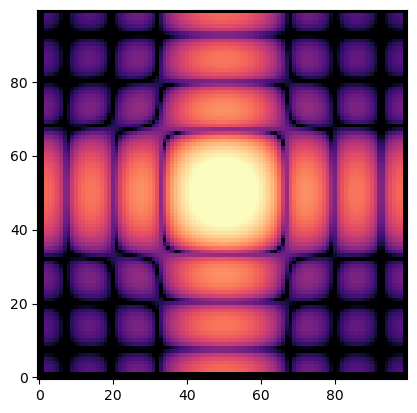

In [4]:
disp_image = waves_t[-1].intensity
disp_image /= disp_image.max()
plt.imshow(np.log10(np.maximum(disp_image, 1.e-8)), vmin = -6, vmax=-0.5, cmap='magma', origin='lower', interpolation='nearest')

## Display Tiger intensity at first prism surface

0.6124915589195199


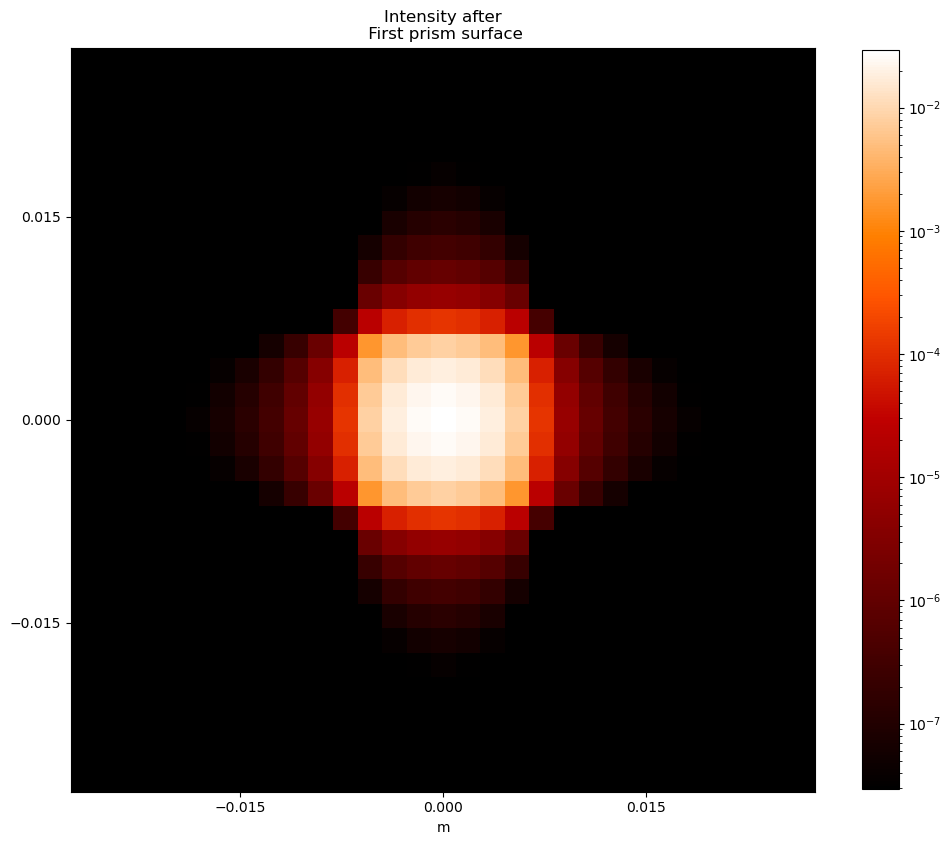

In [5]:
plt.figure(figsize=(12,12))
idx_t = 8
vmax_t = waves_t[idx_t].intensity.max()
waves_t[idx_t].display(imagecrop=.055, scale='log', vmin=1.e-6*vmax_t, vmax=vmax_t, colorbar=True)
print(waves_t[idx_t].intensity.sum())

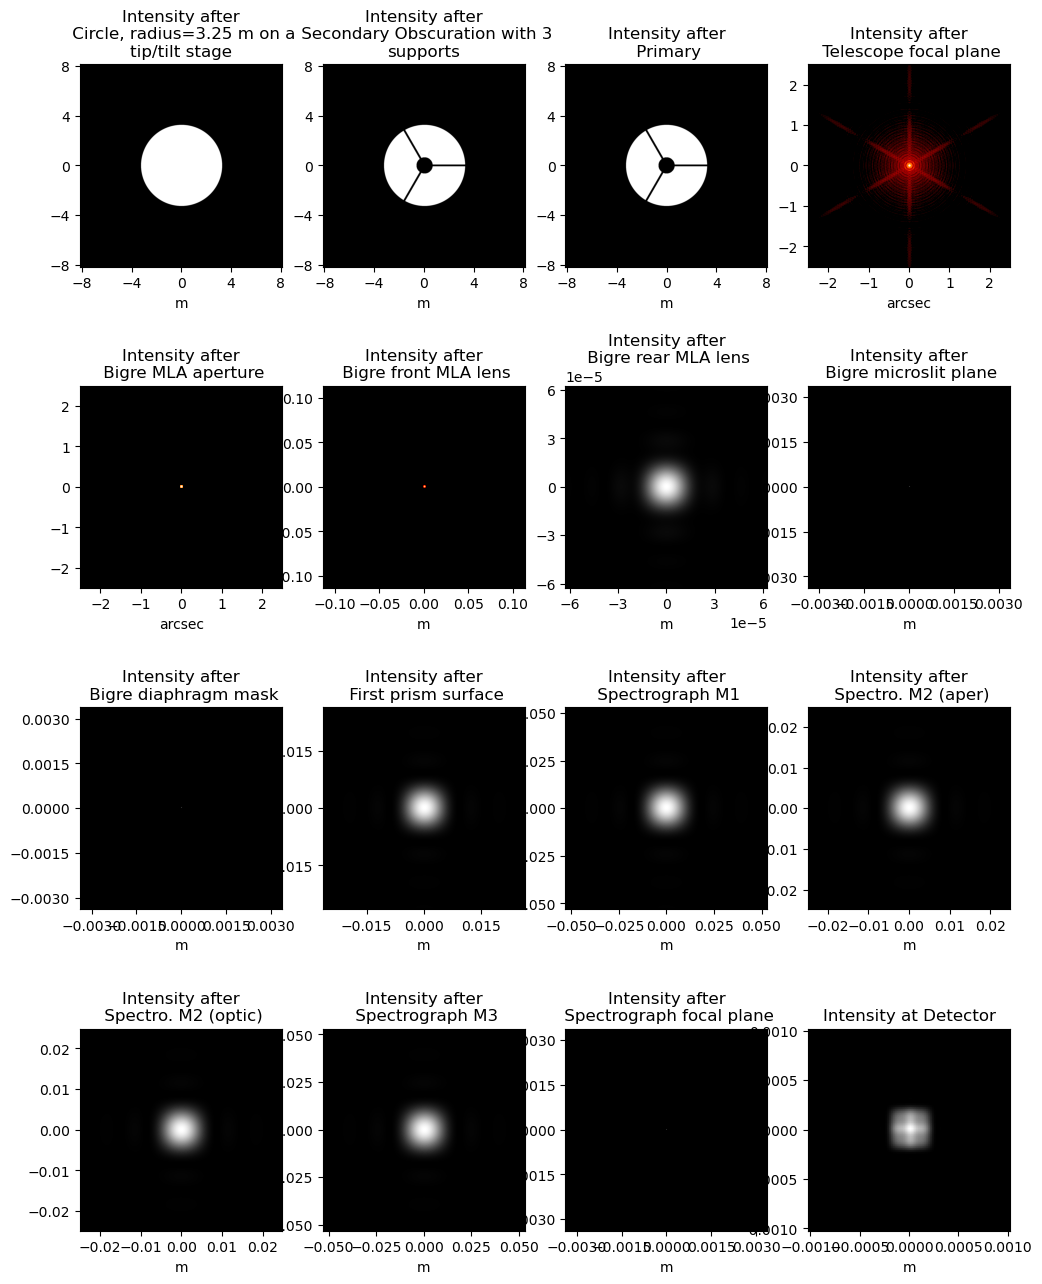

In [6]:
# DEFINE BIGRE VERSION

sys_bigre = poppy.FresnelOpticalSystem(pupil_diameter=pupil_diam, npix=npix)
# Primary aperture:
prim_ap = poppy.CircularAperture(radius=diam/2.)
# Tip-tilt stage (to walk telescope PSF over spaxel):
ttstage = poppy.TipTiltStage(prim_ap, radius=diam/2.)
# Put primary+stage into system:
sys_bigre.add_optic(ttstage)
# Include secondary obscuration:
sys_bigre.add_optic(poppy.SecondaryObscuration(secondary_radius=sec_rad,
                                               n_supports=n_supp,
                                               support_width=supp_wid))
# Add lens to represent focusing effect of primary + magnifier:
sys_bigre.add_optic(poppy.QuadraticLens(fl_pri, name='Primary'))
# Establish telescope focal plane:
sys_bigre.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image,
                                             name='Telescope focal plane'),
                    distance=fl_pri)
# Add MLA aperture:
sys_bigre.add_optic(poppy.SquareFieldStop(size=1.*spaxel_arcsec,  ### <---FIX?!
                                          name='Bigre MLA aperture'))
# Add front Bigre MLA lens:
sys_bigre.add_optic(poppy.QuadraticLens(fl_bigre_1, name='Bigre front MLA lens'))
# Add rear Bigre MLA lens:
sys_bigre.add_optic(poppy.QuadraticLens(fl_bigre_2, name='Bigre rear MLA lens'),
                    distance=(fl_bigre_1+fl_bigre_2))

# Define microslit image plane:
sys_bigre.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Bigre microslit plane'),
                    distance=imdist_bigre)
# Add diaphragm mask:
sys_bigre.add_optic(poppy.SquareAperture(size=1.*dsize_bigre,  ### <---FIX?!
                                          name='Bigre diaphragm mask'))
sys_bigre.planes[-1].wavefront_display_hint = 'intensity'
# Add reference plane at location of first prism surface:
sys_bigre.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='First prism surface'),
                    distance=pr_dist)
sys_bigre.planes[-1].wavefront_display_hint = 'intensity'
# Add spectrograph M1:
sys_bigre.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M1'),
                    distance=(imdist_spec-pr_dist))
# Add spectrograph M2 aperture:
sys_bigre.add_optic(poppy.SquareAperture(size=1.*dsize_m2,  ### <---FIX?!
                                          name='Spectro. M2 (aper)'),
                    distance=offset_m2)
# Add spectrograph M2 optical power:
sys_bigre.add_optic(poppy.QuadraticLens(fl_m2, name='Spectro. M2 (optic)'))
# Add spectrograph M3:
sys_bigre.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M3'),
                    distance=offset_m2)
# Establish detector plane:
sys_bigre.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Spectrograph focal plane'),
                    distance=1.*imdist_spec)
# Add detector:
sys_bigre.add_detector(pixelscale=detscale, fov_pixels=detfov)

# Make everything display intensity:
for iplane in range(len(sys_bigre.planes)):
    sys_bigre.planes[iplane].wavefront_display_hint = 'intensity'

# Tip/tilt if you want it (specified in units of spaxel):
x_shift = 0.
y_shift = 0.
sys_bigre[0].set_tip_tilt(x_shift * spaxel_arcsec * u.arcsec,
                          y_shift * spaxel_arcsec * u.arcsec)

plt.figure(figsize=(12,16))
psf_b, waves_b = sys_bigre.calc_psf(wavelength=1.*u.micron,
                                    display_intermediates=True,
                                    return_intermediates=True)

## Display centered Bigre PSF

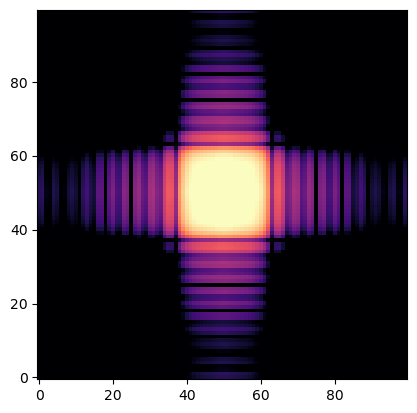

In [7]:
disp_image = waves_b[-1].intensity
disp_image /= disp_image.max()
plt.imshow(np.log10(np.maximum(disp_image, 1.e-8)), vmin = -6, vmax=-.5, cmap='magma', origin='lower', interpolation='nearest')

## Display Bigre intensity at first prism surface

0.6124915589195198


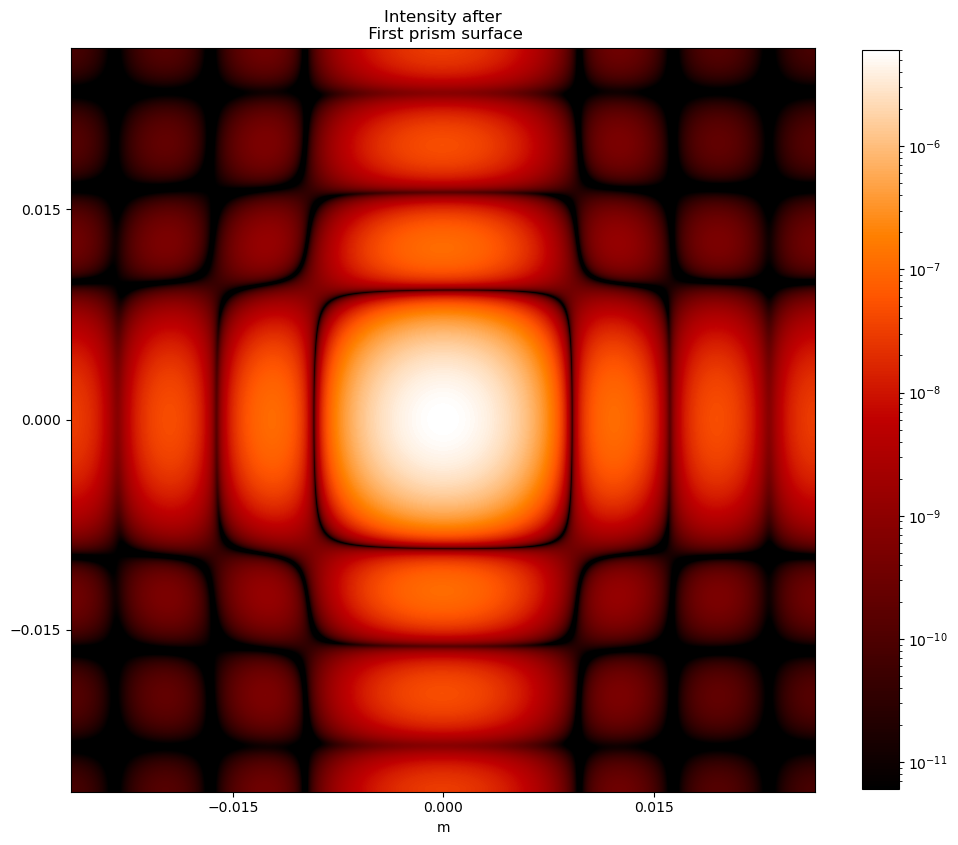

In [8]:
plt.figure(figsize=(12,12))
idx_b = 9
vmax_b = waves_b[idx_b].intensity.max()
waves_b[idx_b].display(scale='log', vmin=1.e-6*vmax_b, vmax=vmax_b, colorbar=True)
print(waves_t[idx_b].intensity.sum())

In [9]:
# Reckoning the full beam width at about 1.5cm from these images
# (and acknowledging that the bigre case looks a bit "bigre"),
# the approximate "observed" input f-ratio is:
f_ratio_input_obs = pr_dist / (1.5e-2 * u.m)
print(f_ratio_input_obs)

11.698466666666667


In [10]:
# This compares to the gemoetric input f-ratio expectation of
f_ratio_input_geo = (fl_pri / diam) * (fl_bigre_2 / fl_bigre_1)
print(f_ratio_input_geo)

15.878746594005449
